In [1]:
import matplotlib.pyplot as plt

from torch.utils.data import DataLoader
from torchvision import transforms
from progressBar import printProgressBar

import medicalDataLoader
import argparse
from utils import *

from UNet_Base import *
import random
import torch
import pdb

from dice_loss import *

from torchmetrics import Dice
from torchmetrics.functional import dice_score

from HausdorffDistance import *

from UNetBis import *

import warnings
warnings.filterwarnings("ignore")

éval : 
- valeur de Dice
- distance Hausdorff
- moyenne des differences sur les surfaces

In [16]:

print('-' * 40)
print('~~~~~~~~  Starting the training... ~~~~~~')
print('-' * 40)

## DEFINE HYPERPARAMETERS (batch_size > 1)
batch_size = 32
batch_size_val = 1000
lr = 0.01    # Learning Rate
epoch = 2 # Number of epochs

root_dir = './Data/'

print(' Dataset: {} '.format(root_dir))

## DEFINE THE TRANSFORMATIONS TO DO AND THE VARIABLES FOR TRAINING AND VALIDATION

transform = transforms.Compose([
    transforms.ToTensor()
])

mask_transform = transforms.Compose([
    transforms.ToTensor()
])

train_set_full = medicalDataLoader.MedicalImageDataset('train',
                                                    root_dir,
                                                    transform=transform,
                                                    mask_transform=mask_transform,
                                                    augment=False,
                                                    equalize=False)

train_loader_full = DataLoader(train_set_full,
                            batch_size=batch_size,
                            worker_init_fn=np.random.seed(0),
                            num_workers=0,
                            shuffle=True)


val_set = medicalDataLoader.MedicalImageDataset('val',
                                                root_dir,
                                                transform=transform,
                                                mask_transform=mask_transform,
                                                equalize=False)

val_loader = DataLoader(val_set,
                        batch_size=batch_size_val,
                        worker_init_fn=np.random.seed(0),
                        num_workers=0,
                        shuffle=False)

## INITIALIZE YOUR MODEL
num_classes = 4 # NUMBER OF CLASSES

print("~~~~~~~~~~~ Creating the UNet model ~~~~~~~~~~")
modelName = 'Test_Model'
print(" Model Name: {}".format(modelName))

## CREATION OF YOUR MODEL
net = UNet(num_classes)

print("Total params: {0:,}".format(sum(p.numel() for p in net.parameters() if p.requires_grad)))

# DEFINE YOUR OUTPUT COMPONENTS (e.g., SOFTMAX, LOSS FUNCTION, ETC)
softMax = torch.nn.Softmax()
loss_fn = torch.nn.CrossEntropyLoss()
#loss_fn = SoftDiceLoss()

## PUT EVERYTHING IN GPU RESOURCES    
if torch.cuda.is_available():
    print('gpu')
    net.cuda()
    softMax.cuda()
    loss_fn.cuda()

## DEFINE YOUR OPTIMIZER
optimizer = torch.optim.Adam(net.parameters(), lr=lr)

### To save statistics ####
lossTotalTraining = []
Best_loss_val = 1000
BestEpoch = 0

directory = 'Results/Statistics/' + modelName

print("~~~~~~~~~~~ Starting the training ~~~~~~~~~~")
if os.path.exists(directory)==False:
    os.makedirs(directory)

## START THE TRAINING

## FOR EACH EPOCH
for i in range(epoch):
    net.train()
    lossEpoch = []
    DSCEpoch = []
    DSCEpoch_w = []
    num_batches = len(train_loader_full)
    
    ## FOR EACH BATCH
    for j, data in enumerate(train_loader_full):

        #plt.imshow(data[0][0,0,:,:]) --> image
        #plt.imshow(data[1][0,0,:,:]) --> label

        ### Set to zero all the gradients
        net.zero_grad()
        optimizer.zero_grad()

        ## GET IMAGES, LABELS and IMG NAMES
        images, labels, img_names = data

        ### From numpy to torch variables
        labels = to_var(labels)
        labels = torch.argmax(labels, dim=1)
        images = to_var(images)

        ################### Train ###################
        #-- The CNN makes its predictions (forward pass)
        #print(images.shape)
        net_predictions = net(images)
        #print(f'prediction : {net_predictions.shape}')
        #print(f'labels : {labels.shape}')

        #-- Compute the losses --#
        # THIS FUNCTION IS TO CONVERT LABELS TO A FORMAT TO BE USED IN THIS CODE
        segmentation_classes = getTargetSegmentation(labels)
        print(f'labels shape {labels.shape}')
        print(f'seg labels shape {segmentation_classes.shape}')
        
        # COMPUTE THE LOSS
        #print(net_predictions.shape, labels.shape)
        #print(type(net_predictions[0,1,:,:]))
        #plt.imshow(net_predictions[0,1,:,:].detach().numpy())
        loss_value = loss_fn(net_predictions, segmentation_classes) # XXXXXX and YYYYYYY are your inputs for the CE
        lossTotal = loss_value

        # DO THE STEPS FOR BACKPROP (two things to be done in pytorch)
        loss_value.backward()
        optimizer.step()

        # THIS IS JUST TO VISUALIZE THE TRAINING 
        lossEpoch.append(lossTotal.cpu().data.numpy())
        printProgressBar(j + 1, num_batches,
                            prefix="[Training] Epoch: {} ".format(i),
                            length=15,
                            suffix=" Loss: {:.4f}, ".format(lossTotal))

    lossEpoch = np.asarray(lossEpoch)
    lossEpoch = lossEpoch.mean()

    lossTotalTraining.append(lossEpoch)

    printProgressBar(num_batches, num_batches,
                            done="[Training] Epoch: {}, LossG: {:.4f}".format(i,lossEpoch))

    # eval
    net.eval()
    del images, labels
    val_loss = 0
    dice_score_ = 0
    
    for j, data in enumerate(val_loader):
        images, labels, img_names = data
        labels = to_var(labels)
        labels = torch.argmax(labels, dim=1)
        images = to_var(images)

        outputLogits = net(images)
        output = softMax(outputLogits)

        val_loss += loss_fn(output, labels).item()  # sum up batch loss

        print(output.shape, labels.shape)

        dice = Dice(num_classes=num_classes)
        
        dice_cof = dice(output, labels).item()
        dice_score_ +=  dice_cof

    val_loss /= len(val_loader.dataset)
    dice_score_ = dice_score_/len(val_loader.dataset)

    print('Validation set: Average loss: {:.4f}\nDice Score : {:.4f}'.format(val_loss, dice_score_))

    ## THIS IS HOW YOU WILL SAVE THE TRAINED MODELS AFTER EACH EPOCH. 
    ## WARNING!!!!! YOU DON'T WANT TO SAVE IT AT EACH EPOCH, BUT ONLY WHEN THE MODEL WORKS BEST ON THE VALIDATION SET!!
    if not os.path.exists('./models/' + modelName):
        os.makedirs('./models/' + modelName)

        torch.save(net.state_dict(), './models/' + modelName + '/' + str(i) + '_Epoch')
        
    np.save(os.path.join(directory, 'Losses.npy'), lossTotalTraining)

----------------------------------------
~~~~~~~~  Starting the training... ~~~~~~
----------------------------------------
 Dataset: ./Data/ 
~~~~~~~~~~~ Creating the UNet model ~~~~~~~~~~
 Model Name: Test_Model
Total params: 60,664
~~~~~~~~~~~ Starting the training ~~~~~~~~~~
labels shape torch.Size([32, 256, 256])
seg labels shape torch.Size([32, 256, 256])
[Training] Epoch: 0 [>              ] 2.6% Loss: 2.3444, labels shape torch.Size([32, 256, 256])
seg labels shape torch.Size([32, 256, 256])
[Training] Epoch: 0 [>              ] 5.3% Loss: 2.0552, labels shape torch.Size([32, 256, 256])
seg labels shape torch.Size([32, 256, 256])
[Training] Epoch: 0 [=>             ] 7.9% Loss: 1.9038, labels shape torch.Size([32, 256, 256])
seg labels shape torch.Size([32, 256, 256])
[Training] Epoch: 0 [=>             ] 10.5% Loss: 1.8233, labels shape torch.Size([32, 256, 256])
seg labels shape torch.Size([32, 256, 256])
[Training] Epoch: 0 [=>             ] 13.2% Loss: 1.7671, labels shape 

torch.Size([24, 256, 256]) torch.Size([90, 256, 256])


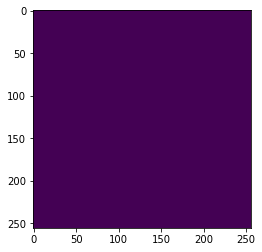

In [17]:
print(segmentation_classes.shape, labels.shape)
plt.imshow(segmentation_classes[15,:,:])

torch.Size([90, 1, 256, 256]) torch.Size([90, 4, 256, 256]) torch.Size([90, 1, 256, 256])


(<AxesSubplot:title={'center':'Class 3'}>,
 Text(0.5, 1.0, 'Class 3'),
 <matplotlib.colorbar.Colorbar at 0x7f9013a1fca0>)

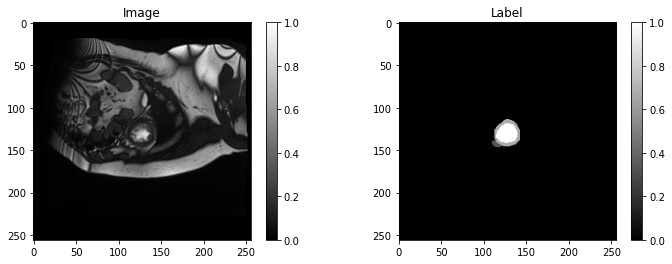

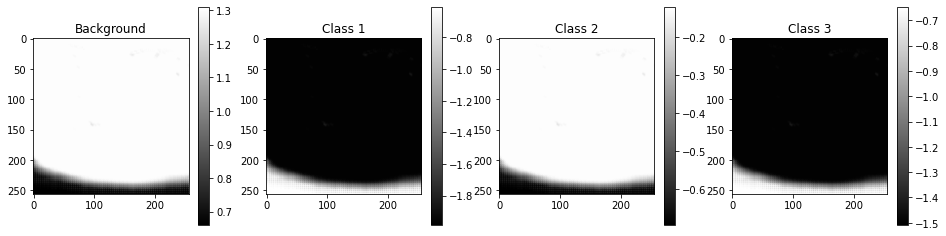

In [18]:
# test

test_set = medicalDataLoader.MedicalImageDataset('test', root_dir)
test_loader = DataLoader(test_set,
                        batch_size=batch_size_val,
                        worker_init_fn=np.random.seed(0),
                        num_workers=0,
                        shuffle=False)

#images, labels, _ = next(iter(train_loader_full))
images, labels, _ = next(iter(val_loader))

plt.figure(1, figsize=(12,4))
plt.subplot(1,2,1), plt.imshow(images[1,0,:,:], cmap='gray'), plt.title('Image'), plt.colorbar()
plt.subplot(1,2,2), plt.imshow(labels[1,0,:,:], cmap='gray'), plt.title('Label'), plt.colorbar()

output = net(images)

print(images.shape, output.shape, labels.shape)
plt.figure(2, figsize=(16,4))
plt.subplot(1,4,1), plt.imshow(output[1,0,:,:].detach().numpy(), cmap='gray'), plt.title('Background'), plt.colorbar()
plt.subplot(1,4,2), plt.imshow(output[1,1,:,:].detach().numpy(), cmap='gray'), plt.title('Class 1'), plt.colorbar()
plt.subplot(1,4,3), plt.imshow(output[1,2,:,:].detach().numpy(), cmap='gray'), plt.title('Class 2'), plt.colorbar()
plt.subplot(1,4,4), plt.imshow(output[1,3,:,:].detach().numpy(), cmap='gray'), plt.title('Class 3'), plt.colorbar()

tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)

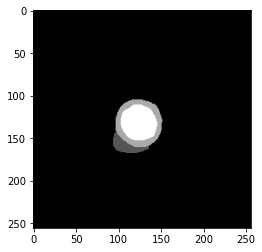

In [4]:
plt.imshow(labels[15,0,:,:], cmap='gray')
for i in range(256):
    for j in range(256):
        print(labels[15,0,:,:][i,j])

In [5]:
losses = np.load('Results/Statistics/Test_Model/Losses.npy')
losses

array([0.47675204, 0.04086378], dtype=float32)

In [6]:
epoch = np.load('models/Test_Model/0_Epoch')
epoch